## Постановка задачи

Интресно посмотреть обобщенный портрет пользователя, который часто публикует посты, и пользователя, который публикует редко.
А так же есть ли различия между этими двумя группами и если есть, то понять какие.

# Содержание
1. [Построение выборки.](#sample)<br>
  1.1. [Формируем список `VK id`.](#vk_id_scope)<br>
  1.2. [Получаем пользовательскую информацию.](#user_info)<br>
  1.3. [Считаем друзей пользователей.](#friends_count)<br>
2. [Получаем посты пользователей с их стен.](#get_walls)<br>
  2.1. [Загрузка постов.](#download_walls)<br>
  2.2. [Считаем количество постов.](#count_posts)<br>       
3. [Предобработка данных.](#eda)<br>
4. [Построение классификатора.](#classifier)<br>
    4.1. [Попытка построения модели на `CatboostClassifier`.](#catboost)<br>
    4.2. [Выводы о модели.](#catboost_results)<br>
5. [Выводы.](#conclusions)<br>


In [1]:
# Загрузим все нужные библиотеки
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime as dt
import vk
import vk_api
import random
import json
from tqdm import tqdm
from pandas.io.json import json_normalize
import sys
import pickle
from operator import itemgetter
from dateutil.relativedelta import relativedelta
import yaml
import ast
import matplotlib.ticker as ticker
%matplotlib inline


# Укажем путь для папки, куда будем сохранять релевантные материлы
RAW='raw/'

In [2]:
# Получаем токен и авторизуиуремся в vk api
TOKEN ='3ea3cd2b5291a156abf031512ee87abe97274409f6387c683acb2cd588dfc101e57dc3abaf1e18c90d***'#&expires_in=0&user_id=32313854
MY_ID = '32313854'

session = vk.Session(access_token = TOKEN)
api = vk.API(session)

# 1. Построение выборки.
<a id='sample'></a>

## 1.1. Формируем список `VK id`.
<a id='vk_id_scope'></a>

Для начала я решил рандомно сгенерировать 9-значные `vk id`, но столкнулся с тем, что тяжело набрать достаточный объем выборки, тк при генерации получалось много забаненных или удаленных пользователей.
Также, я думал использовать [каталог пользователей ВК](https://vk.com/catalog.php). <br> 
В итоге, чтобы выборка была более целостной и актулаьной, я решил посмотреть на свое окружение с глубиной в 2 друга. Соответственно, нам нужно скачать `vk id` своих друзей и потом `vk id` их друзей.<br> 
Поэтому напишем функцию, которая берёт наших друзей и скачивает айдишники их друзей, и складывает это все в отдельный `list`.

In [3]:
def GetFriends():
    my_friends = api('friends.get') 

    friends_of_friends = []

    for friend in my_friends:
        try:
            time.sleep(0.5)
            friend_list = api.friends.get(user_id=friend)
            friends_of_friends += friend_list
        except Exception:
            continue
    return friends_of_friends

Получаем объект с `vk id` друзей моих друзей.

In [4]:
friends_of_friends = GetFriends()

Очистим получившийся `list` от дубликатов: пользователей, которые находятся в друзьях у нескольких других пользователей.

In [5]:
friends_of_friends = pd.read_csv(RAW + 'friends_ids.csv.gz', sep=',', compression='gzip' )

In [13]:
print('Всего друзей в ближайшем окружении получилось: {} пользователей.'.format(len(friends_of_friends)))
unique_friends_of_friends = pd.Series(friends_of_friends).unique()
print('Уникальных же id получилось меньше: {} пользователей.'.format(len(unique_friends_of_friends)))

# Сохраним на всякий случай.
pd.DataFrame(friends_of_friends).to_csv( RAW + 'friends_ids.csv.gz', sep=',', index=False, compression='gzip')

Всего друзей в ближайшем окружении получилось: 141760 пользователей.
Уникальных же id получилось меньше: 115543 пользователей.


## 1.2. Получаем пользовательскую информацию.
<a id='user_info' ></a>

In [ ]:
def GetUserInfo(id_list):
    
    frame = pd.DataFrame([])

    for i in range(len(id_list)//1000+1):
        time.sleep(0.5)
        users = api.users.get(user_ids=id_list[i*1000:(i+1)*1000], access_token = TOKEN,
                                  fields=['sex', 'bdate', 'city', 'home_town', 'personal','last_seen',
                                          'relation','universities','verified', 'followers_count'])
        frame = frame.append(pd.DataFrame(users))
    frame = frame[frame.deactivated.isnull()]
    return frame

Используем уникальные `vk id`, которые мы получили и библиотеку **`tqdm`** для того, чтобы понимать сколько времени займет этот цикл.<br>
По умолчанию список передаваемых `user_id`, должен составлять не более 1000. Соответственно, при нашем количестве пользователей у нас получилось 126 итераций.<br>
Далее, мы разворачиваем JSON в датафрейм, а после очищаем от забаненных и удаленных страниц через поле `deactivated`.
Это можно было бы сделать внутри цикла, но по какой-то причине терялись поля метода `personal`.
Поэтому было принято решение трансформировать JSON во фрейм и сделать очистку после цикла. <br>
Также, метод `counters` содержит важную информацию по количеству друзей и подписчиков, но требует посылать единичные запросы к `API`, что заняло бы слишком много времени и неизбежно выскочила бы `TimeoutError`. Поэтому используем объект `followers_count` и посчитаем количество друзей позже самостоятельно.

Всего на цикл ушло времени: _~ 4 минуты_. 

In [327]:
users = []

for i in tqdm(range(len(unique_friends_of_friends.values)//1000+1), unit='request'):
    time.sleep(0.3)
    user = api.users.get(user_ids=unique_friends_of_friends[i*1000:(i+1)*1000].values, access_token = TOKEN,
                         fields=['sex', 'bdate', 'city', 'home_town', 'personal', 'last_seen',
                                 'relation','universities','verified', 'followers_count'])

    users += user
    
users = json_normalize(users) # преобразуем в фрейм
users = users[users.deactivated.isnull()] # очищаем от забаненных и заблокированных

100%|██████████| 116/116 [04:13<00:00,  2.01s/request]


Посмотрим на выборку.

In [16]:
print('В очищенной выборке вышло {} пользователей.'.format(users.shape[0]))
print('---')
print(users.columns)
users.head(3)

В очищенной выборке вышло 113880 пользователей.
---
Index(['bdate', 'city', 'deactivated', 'first_name', 'followers_count',
       'home_town', 'last_name', 'last_seen.platform', 'last_seen.time',
       'personal.alcohol', 'personal.inspired_by', 'personal.langs',
       'personal.life_main', 'personal.people_main', 'personal.political',
       'personal.religion', 'personal.smoking', 'relation',
       'relation_partner.first_name', 'relation_partner.id',
       'relation_partner.last_name', 'sex', 'uid', 'universities', 'verified'],
      dtype='object')


,bdate,city,deactivated,first_name,followers_count,home_town,last_name,last_seen.platform,last_seen.time,personal.alcohol,...,personal.religion,personal.smoking,relation,relation_partner.first_name,relation_partner.id,relation_partner.last_name,sex,uid,universities,verified
0,9.8.1989,155.0,NaN,Женя,1858.0,Химки,Ясырева,1.0,1.517239e+09,NaN,...,Христианство,NaN,4.0,Юрий,75607.0,Ясырев,1,6932,"[{'id': 249, 'country': 1, 'city': 155, 'name'...",0.0
1,8.2.1989,1.0,NaN,Olga,1127.0,NaN,Zakharova,4.0,1.517080e+09,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,6984,NaN,0.0
2,NaN,0.0,NaN,Наталия,304.0,,Аксёнова,7.0,1.513618e+09,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,1,7074,"[{'id': 219, 'country': 0, 'city': 0, 'name': ...",0.0


## 1.3. Считаем друзей пользователей.
<a id='friends_count' ></a>

Также, важной описательной статистикой является количество друзей пользователя. Её я посчитал используя обертку на стандартный `api` - `vk_api` через метод `VkRequestsPool`.

In [ ]:
with vk_api.VkRequestsPool(vk_session) as pool:
        friends = pool.method_one_param('friends.get', 
                                        key='user_id',  
                                        values = users.uid.tolist())

friendss_count_dict = pd.DataFrame(friends.result).stack()['count']

# Сохранимся
friends_counts = pd.DataFrame({'user_id': friendss_count_dict.index,
                              'friends_count': friendss_count_dict.values}, 
                             columns = ['user_id', 'friends_count'])

friends_counts.to_csv(RAW + 'friends_counts.csv.gz', compression='gzip', index=False)

Сделаем словарь и замэппим его по `vk id`.

In [ ]:
friends_counts_dict = pd.Series(friends_counts['friends_count'].values,
                             index=friends_counts['user_id']).to_dict()

users['friends_qty'] = users['uid'].map(friends_counts_dict)

# 2. Получаем посты пользователей с их стен.
<a id='get_walls' ></a>

## 2.1. Загрузка постов.
<a id='download_walls' ></a>

Напишем цикл для скачивания постов у пользователей по `vk id`.

In [ ]:
vk_session = vk_api.VkApi(token=TOKEN)
with vk_api.VkRequestsPool(vk_session) as pool:
        walls = pool.method_one_param('wall.get', 
                                        key='owner_id',  
                                        values = users.uid.tolist())

wall_count_dict = pd.DataFrame(walls.result).stack()['count']

# Сохраним наш результат запросов.
wall_counts = pd.DataFrame({'user_id': wall_count_dict.index,
                           'wall_count': wall_count_dict.values}, 
                             columns = ['user_id', 'wall_count'])

wall_counts.to_csv(RAW + 'wall_counts.csv.gz', compression='gzip', index=False)
pd.DataFrame(walls.result).to_csv(RAW +'wall.csv.gz',compression='gzip',index=False)

По каким-то причинам у меня не вышло выкачать стены по всем пользователям. Возможно, это связанно со слишком большим количеством постов на их страницах или из-за ограничения метода `VkRequestsPool`, тем не менее на запросы по некоторым `vk id` объект стены возвращен не был. Также нам вернулись 20 последних постов на стене пользователя, соответсвенно мы не видим полной стены, но можем довольно достоверно понять, что постит много или мало.<br>
Однако получилось вытащить стены ~ по **47K пользователям, так что дальнейший анализ проведен на этой выборке**. <br>

In [4]:
users = pd.read_csv(RAW + 'user_info_fin.csv.gz', compression='gzip')
#users.to_csv(RAW + 'user_info_47k.csv.gz', compression='gzip', index=False)

Сохраним все в `pickle`, так как Jupyter не сможет распаковать `wall.csv.gz` не крэшнувшись. 
В свою очередь `pickle` занимает больше места, но не крэшит Jupyter и работает быстро.

In [ ]:
with open('raw/walls.p', 'wb') as f:
    pickle.dump(walls.result, f)

In [3]:
wall_pickle = pickle.load(open("raw/walls.p", "rb" ))

## 2.2. Считаем количество постов.

<a id='count_posts' ></a>

### 2.2.1. Историческое количество постов на стене.

Сначала соберем количество постов по каждому `vk id`. Проитерируемся по всем `vk id` в нашем JSON объекте, после чего проитерируемя по кажому объекту и зайдем в метку `'count'` и достанем количество постов.

In [ ]:
user_id_list = []
wall_count = []

for user_id in list(wall_pickle.keys()):
    user_id_list.append(user_id)
    
for i in user_id_list:
    wall_count.append(wall_pickle[i]['count'])


posts_count = pd.DataFrame({'user_id':user_id_list, 'wall_count':wall_count}, columns = ['user_id', 'wall_count'])

### 2.2.2. Количество постов за разные ретродаты.

Теперь пройдемся по каждому `vk id`, проверяя записи постов на стене на соответствие по разным ретродатам. Я подумал, что логично посчитать количество постов за сутки/ 3 дня/ за неделю/ 2 недели и месяц. <br>

_P.S._ В случае, когда мы проверяем и отсекаем посты пользователей в зависимости от времени, имеет смысл брать дату ровно в 12 ночи текущего дня, тк стандартный метод `now()` возвращает текущую дату с точностью до милисекунды. <br>

_P.S.S._ При дальнейшем анализе, ретро-окна в сутки/ 3 дня и неделю оказались слишком маленькими и были не очень информативными, поэтому не использовались.

In [982]:
posts_today = []
posts_3_days = []
posts_week = []
posts_2_weeks = []
posts_month = []
posts_today_dates = []
posts_3_days_dates = []
posts_week_dates = []
posts_2_weeks_dates = []
posts_month_dates = []


# Задаем даты по которым будем проверять.
today = pd.Timestamp(2018,1,26,0,0,0) 
three_days_ago = (pd.Timestamp(2018,1,26,0,0,0)- pd.Timedelta(days=3))
week_ago = (pd.Timestamp(2018,1,26,0,0,0) - pd.Timedelta(weeks=1))
two_weeks_ago = (pd.Timestamp(2018,1,26,0,0,0) - pd.Timedelta(weeks=2))
month_ago = (pd.Timestamp(2018,1,26,0,0,0) - pd.Timedelta(weeks=4))

# Сам цикл
for user_id in list(wall_pickle.keys()):
    for k in wall_pickle[user_id]:
        for i in wall_pickle[user_id]['items']:

            if ((pd.to_datetime(i['date']*10e8)) >= today):
                date_1 = pd.to_datetime(i['date']*10e8)
                posts_today_dates.append(date_1)
                posts_today.append(user_id)
            if ((pd.to_datetime(i['date']*10e8)) >= three_days_ago):
                date_2 = pd.to_datetime(i['date']*10e8)
                posts_3_days_dates.append(date_2)
                posts_3_days.append(user_id)
            if ((pd.to_datetime(i['date']*10e8)) >= week_ago):
                date_3 = pd.to_datetime(i['date']*10e8)
                posts_week_dates.append(date_3)
                posts_week.append(user_id)
            if ((pd.to_datetime(i['date']*10e8)) >= two_weeks_ago):
                date_4 = pd.to_datetime(i['date']*10e8)
                posts_2_weeks_dates.append(date_4)
                posts_2_weeks.append(user_id)
            if ((pd.to_datetime(i['date']*10e8)) >= month_ago):
                date_5 = pd.to_datetime(i['date']*10e8)
                posts_month_dates.append(date_5)
                posts_month.append(user_id)

Сохраним количество постов, чтобы потом иметь под рукой и сделаем словари, чтобы замэппить на нашу выборку.

In [989]:
posts_today_frame = pd.DataFrame({'user_id':posts_today,'timestamp':posts_today_dates}, 
                                 columns=['user_id', 'timestamp'])
posts_today_frame = posts_today_frame.drop_duplicates(['user_id', 'timestamp'])
posts_today_frame = pd.DataFrame(posts_today_frame.groupby('user_id').size()).reset_index()
posts_today_frame.columns=['user_id','daily_posts']
#####
posts_3_days_frame = pd.DataFrame({'user_id':posts_3_days,'timestamp':posts_3_days_dates}, 
                                 columns=['user_id', 'timestamp'])
posts_3_days_frame = posts_3_days_frame.drop_duplicates(['user_id', 'timestamp'])
posts_3_days_frame = pd.DataFrame(posts_3_days_frame.groupby('user_id').size()).reset_index()
posts_3_days_frame.columns=['user_id','3_day_posts']
#####
posts_week_frame = pd.DataFrame({'user_id':posts_week,'timestamp':posts_week_dates}, 
                                 columns=['user_id', 'timestamp'])
posts_week_frame = posts_week_frame.drop_duplicates(['user_id', 'timestamp'])
posts_week_frame = pd.DataFrame(posts_week_frame.groupby('user_id').size()).reset_index()
posts_week_frame.columns=['user_id','week_posts']
#####
posts_2_weeks_frame = pd.DataFrame({'user_id':posts_2_weeks,'timestamp':posts_2_weeks_dates}, 
                                 columns=['user_id', 'timestamp'])
posts_2_weeks_frame = posts_2_weeks_frame.drop_duplicates(['user_id', 'timestamp'])
posts_2_weeks_frame = pd.DataFrame(posts_2_weeks_frame.groupby('user_id').size()).reset_index()
posts_2_weeks_frame.columns=['user_id','2_weeks_posts']
#####
posts_month_frame = pd.DataFrame({'user_id':posts_month,'timestamp':posts_month_dates}, 
                                 columns=['user_id', 'timestamp'])
posts_month_frame = posts_month_frame.drop_duplicates(['user_id', 'timestamp'])
posts_month_frame = pd.DataFrame(posts_month_frame.groupby('user_id').size()).reset_index()
posts_month_frame.columns=['user_id','month_posts']
#####
total_posts = posts_count.merge(posts_today_frame, how='left', on='user_id').merge(posts_3_days_frame, how='left', on='user_id').merge(posts_week_frame, how='left', on='user_id').merge(posts_2_weeks_frame, how='left', on='user_id').merge(posts_month_frame, how='left', on='user_id')
total_posts = total_posts.sort_values(by=['month_posts','week_posts', '3_day_posts', 'daily_posts'], ascending=False)
total_posts = total_posts.fillna(0)
total_posts.to_csv(RAW +'total_posts_fin.csv.gz', compression='gzip')

In [1015]:
total_posts = posts_count.merge(posts_today_frame, how='left', on='user_id').merge(posts_3_days_frame, how='left', on='user_id').merge(posts_week_frame, how='left', on='user_id').merge(posts_2_weeks_frame, how='left', on='user_id').merge(posts_month_frame, how='left', on='user_id')
total_posts = total_posts.sort_values(by=['month_posts','week_posts', '3_day_posts', 'daily_posts'], ascending=False)
total_posts = total_posts.fillna(0)

Пересечем с нашей выборкой постов, которые удалось скачать, чтобы оставить только те данные, которыми обладаем.
После объединим все в один фрейм и объединим с нашей ключевой таблицей.

In [997]:
u = []
for user_id in list(wall_pickle.keys()):
    u.append(user_id)

In [1016]:
cleaned_total_posts = total_posts[total_posts['user_id'].isin(u)]
cleaned_total_posts.to_csv(RAW+'cleaned_total_posts.csv.gz', compression='gzip', index=False)

In [1020]:
users = pd.merge(users,cleaned_total_posts, how='inner', left_on = 'uid', right_on = 'user_id')

In [1023]:
# Сохранимся
users.to_csv(RAW + 'user_info_fin.csv.gz', compression='gzip', index=False)

### 2.2.3. Посчитаем посты из инстаграма.

Я также решил посчитать посты, которые замэппились в `VK` по привязке из инстаграма. Если у пользователя синхронизирован инстаграм и `VK` и включен авто-постинг, то чем больше публикаций в инстаграме, тем больше постов на стене в `VK`.

In [1056]:
user_ids = []
platform_dates = []
post_platform = []

for user_id in list(wall_pickle.keys()):
    #for k in wall_pickle[user_id]:
        for i in wall_pickle[user_id]['items']:
            try:
                post_platform.append(i['post_source']['platform'])
                user_ids.append(user_id)
            except KeyError:
                continue

Видно, что `instagram` занимает некоторый процент на стенах пользователей и может характеризовать тех, кто постит много.

In [1065]:
platform_types = pd.DataFrame({'user_id':user_ids,'platform': post_platform}, columns = ['user_id','platform'])

instagram_posts = platform_types.groupby(['user_id','platform']).size().unstack().reset_index()[['user_id', 'instagram']]

users = pd.merge(users,instagram_posts, left_on='uid',right_on='user_id',how='left')

In [1064]:
users.drop(['user_id_y', 'instagram_y'], axis=1, inplace=True)

Умозрительно, что **постов в инстаграме у женщин больше** в любой "весовой категории". Женщины в среднем более склонны делиться и выставлять фотографии в соцсетях.

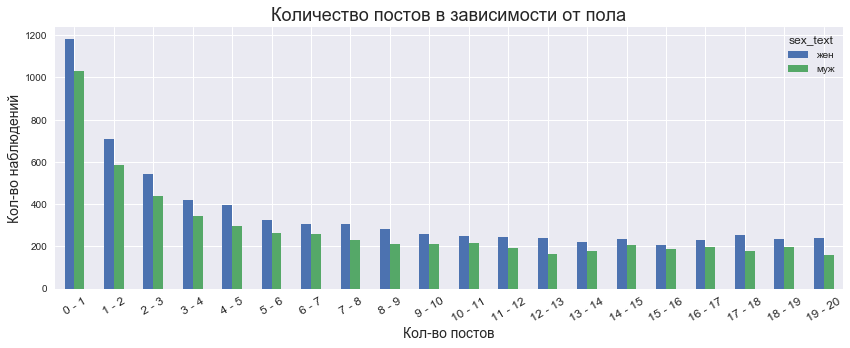

In [1066]:
users.groupby([users['sex_text'],pd.cut(users['instagram'],35)]).size().unstack().T.plot(kind='bar',rot=30, figsize=(12,5))
### преобразуем катгории в лэйблы ###
cats = users.groupby([users['sex_text'],pd.cut(users['instagram'],35)]).size().unstack().T.index
cats_from = cats.astype(str).str.strip('(]').str.split('.').str[0]
cats_to = cats.astype(str).str.strip('(]').str.split('.').str[1].str.split(',').str[1]
new_labels = cats_from+' -'+cats_to 
###

plt.title('Количество постов в зависимости от пола', fontsize=18)
plt.xlabel('Кол-во постов', fontsize=14)
plt.ylabel('Кол-во наблюдений', fontsize=14)
ax = plt.gca()
ax.set_xticklabels(new_labels, fontsize=12)
plt.tight_layout()
plt.show()

## 3.2. Предобработка данных.
<a id='eda' ></a>

Сразу напишем функции для разбиения категорий по количеству постов, которые были посчитаны выше. Для удобства было решено использовать ретро-окна в неделю/ 2 недели и месяц.<br>

Для визуализации будем использовать `violinplot`, чтобы посмотреть на плотности распределений в категориях и разбиение по полу.<br>
Также для простых распределений будем использовать `barplot`.

Для анализа возьмем часть выборки в 47К, по которым нам удалось скачать стены. Те характеристики, которые отличают пользователей по количеству постов в большую сторону, я буду выделять **жирным шрифтом**, а в _меньшую - курсивом_.

In [95]:
# sns.set(rc={'figure.figsize':(15.7,12.27)})
# sns.set(context="paper", palette="colorblind", style="darkgrid")

In [1027]:
def violin_by_cat(users, column, width, height):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=False, sharey=True, figsize = (width, height))
    ax1 = sns.violinplot(x = column, y=users["week_posts"], hue='sex_text', inner='box',scale='area',
                         split=True,data=users[users['sex_text'] != 'Не указан'],capsize=.1,ax=ax1)
    ax2 = sns.violinplot(x = column, y=users["2_weeks_posts"], hue='sex_text',inner='box',scale='area',
                      split=True,data=users[users['sex_text'] != 'Не указан'],capsize=.1,ax=ax2)
    ax3 = sns.violinplot(x = column, y=users["month_posts"], hue='sex_text',inner='box',scale='area',
                         split=True,data=users[users['sex_text'] != 'Не указан'],capsize=.1,ax=ax3)

Заполним категориальные признаки там, где пользователь их не указан на _'Не указано'_, чтобы была видна полная картина происходящего.

In [167]:
column_filter = [col for col in users if col.startswith('personal')]
users[column_filter] = users[column_filter].fillna('Не указано')

### 3.2.1. Пол

Сразу поменяем пол в привычное текстовое представление и создадим бинарную переменную (1/0).
В нашей выборке превалируют мужчины, но соотношение можно считать сбалансированным:**`{'female': 44%,'male': 56%}`**.
При первом взгляде на распределение постов за месяц по полу ничего необычного не видно. <br>

При сравнении пропорций постов между полами видно, что большинство людей не постят или имеют несколько постов за месяц. Также видно небольшую группу людей в районе 38 и 40 постов за месяц у обоих полов.<br>

Пол, как фактор, на постинг не влияет - женщины не постят больше мужчин, как многие думают.

In [27]:
users['sex'] = users['sex'].apply(lambda x: 1 if x=='2.0' else (0 if x=='1.0' else np.nan))
users['sex_text'] = users['sex'].apply(lambda x: 'муж' if x== 1 else ('жен' if x== 0 else 'Не указан'))

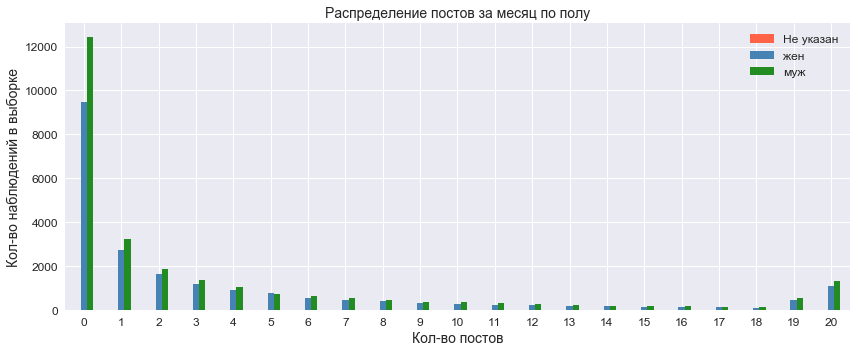

In [9]:
users.groupby(['sex_text', 'month_posts']).size().unstack().unstack().unstack().plot(kind='bar',rot=0, figsize=(12,5), color=['tomato', 'steelblue','forestgreen'])
plt.title('Распределение постов за месяц по полу', fontsize=14)
plt.ylabel('Кол-во наблюдений в выборке', fontsize=14)
plt.xlabel('Кол-во постов', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
### Преобразуем лэйблы ###
new_labels = users.groupby(['sex_text', 'month_posts']).size().unstack().unstack().unstack().index
new_labels = np.array(new_labels).astype(int)
###
ax = plt.gca()
ax.set_xticklabels(new_labels, fontsize=12)
plt.tight_layout()

plt.tight_layout()

### 3.2.2. Образование

Так как поле `universities` может отличаться по иерархии - пользователь может указывать несколько образований или не указывать вообще, то я решил сделать несколько преобразований: <br>
* Выделить пользователей с законченным высшим образованием;
* Выделить степени образования (выпускник-бакалавр/специалист/магистр; студент-бакалавр/специалист/магистр; аспирант...);
* Выделить пользователей которые учатся в топ-10 университетах.

#### Наличие высшего образования

Тут просто отсеим студентов и посмотрим на распределение в разрезе пола. 
Я также отшкалировал графики по площади виолончели, что поможет понять и характер распределения количества постов за временн**о**е окно по категориям и как распределение зависит от пола.<br>

In [173]:
higher = ['Выпускник (бакалавр)','Выпускник (специалист)','Доктор наук', 'Выпускник (магистр)','Кандидат наук','Аспирант']

users['is_higher'] = users['education_level'].apply(lambda x: 1 if x in higher else ('Не указан' if x=='Не указано' else 0))

Если посмотреть на график накопления постов за месяц (нижний график), то видно, что, во-первых, мужчины более склонны указывать о своем образовании, особенно о высшем. Несмотря на то, что в выборке присутсвует ~ равное соотношение полов, женщины не афишируют свое образование так активно как мужчины.<br>

Вместе с тем, женщины с высшим образованием постят на своей странице больше, чем мужчины. Например, на месячном графике видно, что концентрация женщин с максимальным количеством постов растнута в диапазоне от **`(30, max]`** постов, в то время как у мужчин наблюдяется пик в районе **`38-40`** постов.

Пока не очень ясна зависимость количества постов от образования, но можно разбить уровень образование на степени.

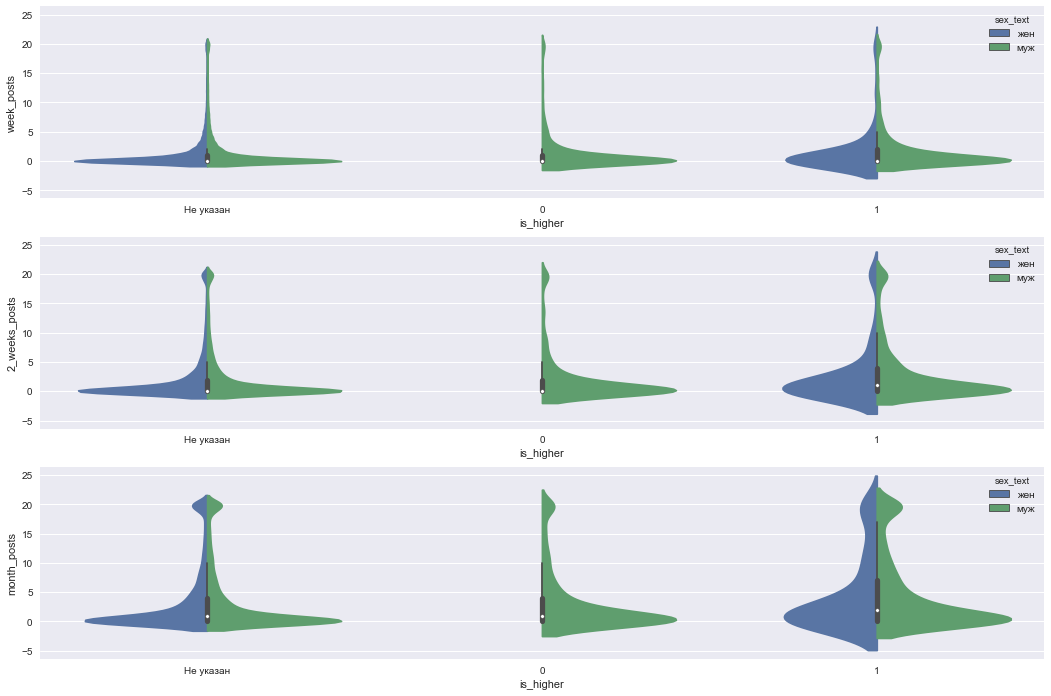

In [1029]:
violin_by_cat(users,'is_higher',18,12)

#### Степени образования

Как видим, люди не склонны указывать уровень образования.

In [174]:
(users['education_level'].apply(lambda x: 'Выпускник' if 'Выпускник' in str(x) else \
                                                   ('Студент' if 'Студент' in str(x) else \
                                                   ('Аспирант' if 'Аспирант' in str(x) else \
                                                   ('Кандидат наук' if 'Кандидат наук' in str(x) else \
                                                   ('Доктор наук' if 'Доктор наук' in str(x) else 'Не указано'
                                                   )))))).value_counts(normalize=True)*100

Не указано       92.393067
Выпускник         3.592865
Студент           3.182192
Доктор наук       0.440158
Аспирант          0.242192
Кандидат наук     0.149527
Name: education_level, dtype: float64

Разобъем более детально.

In [42]:
users.drop_duplicates('uid', inplace=True)

users['education_level'] = users.universities.apply(lambda x: 'Выпускник (бакалавр)' if 'Выпускник (бакалавр)' in str(x) else \
                                                   ('Выпускник (магистр)' if 'Выпускник (магистр)' in str(x) else \
                                                   ('Выпускник (специалист)' if 'Выпускник (специалист)' in str(x) else \
                                                   ('Студент (бакалавр)' if 'Студент (бакалавр)' in str(x) else \
                                                   ('Студент (магистр)' if 'Студент (магистр)' in str(x) else \
                                                   ('Студент (специалист)' if 'Студент (специалист)' in str(x) else \
                                                   ('Аспирант' if 'Аспирант' in str(x) else \
                                                   ('Кандидат наук' if 'Кандидат наук' in str(x) else \
                                                   ('Доктор наук' if 'Доктор наук' in str(x) else 'Не указано'
                                                   )))))))))

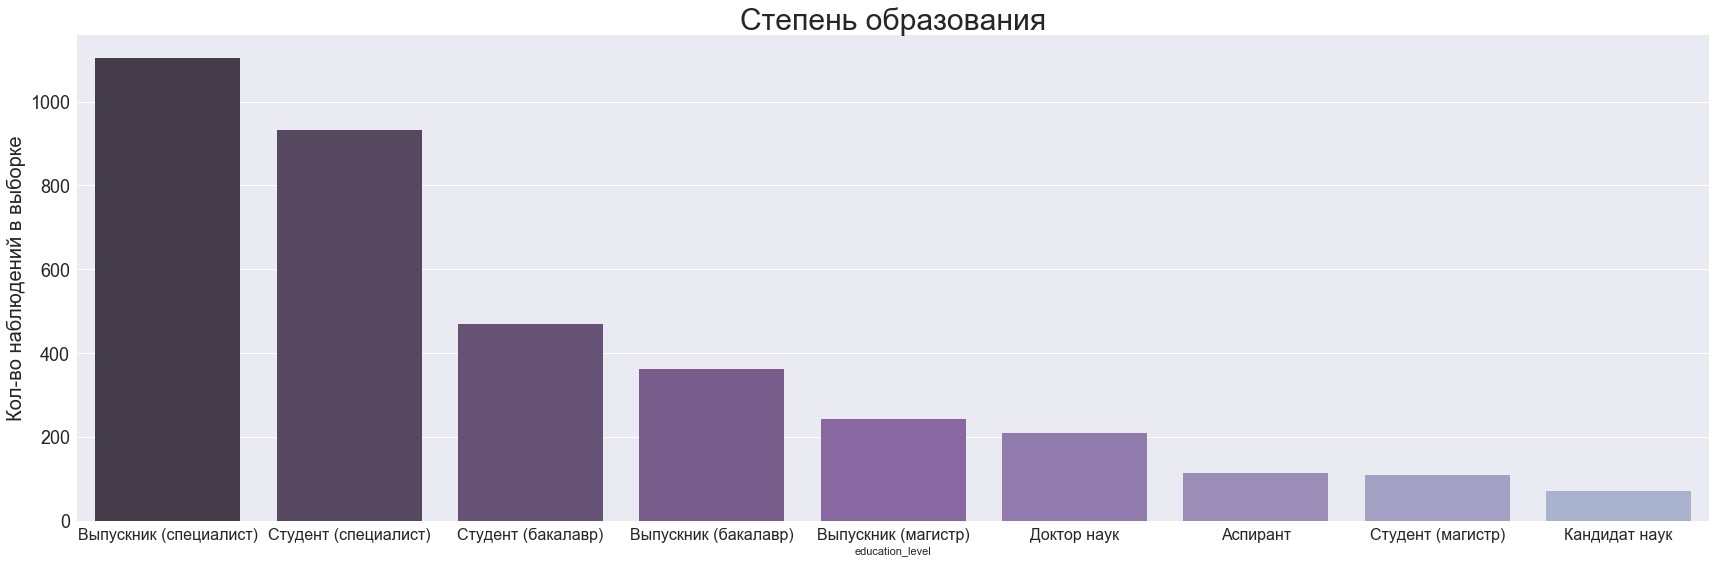

In [1042]:
order = ['Выпускник (специалист)','Студент (специалист)', 'Студент (бакалавр)','Выпускник (бакалавр)',
         'Выпускник (магистр)','Доктор наук', 'Аспирант','Студент (магистр)', 'Кандидат наук']
sns.factorplot(x="education_level", data=users[users['education_level'] != 'Не указано'], kind="count",
                   palette="BuPu_d", size=8, aspect=3, order = order)
plt.title('Степень образования', fontsize=30)
plt.ylabel('Кол-во наблюдений в выборке', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)

plt.tight_layout()

Посмотрим на динамику постинга по уровню образования. <br>
Сразу бросается в глаза, что немногие женщины, которые указали свое образование, сконцентрировались в основном в ыаспирантах/кандидатах и докторах наук. <br>
**Женщины аспиранты и кандидаты наук** постят, больше чем доктора наук, а **мужчины выпускники** постят больше, чем _мужчины студенты_ почти всех категорий. <br>

Как видно по межквартильному размаху больше всего постят **кандидаты наук/выпускники магистры**, а меньше всего, на удивление, _студенты бакалавры_.<br>

В целом, **выпускники высших степеней** постят больше в месяц, чем остальные выпускники. Если сравнивать по полу, то видно, что **женщины доктора наук** постят больше, чем мужчины доктора наук, а кандидаты наоборот.<br>

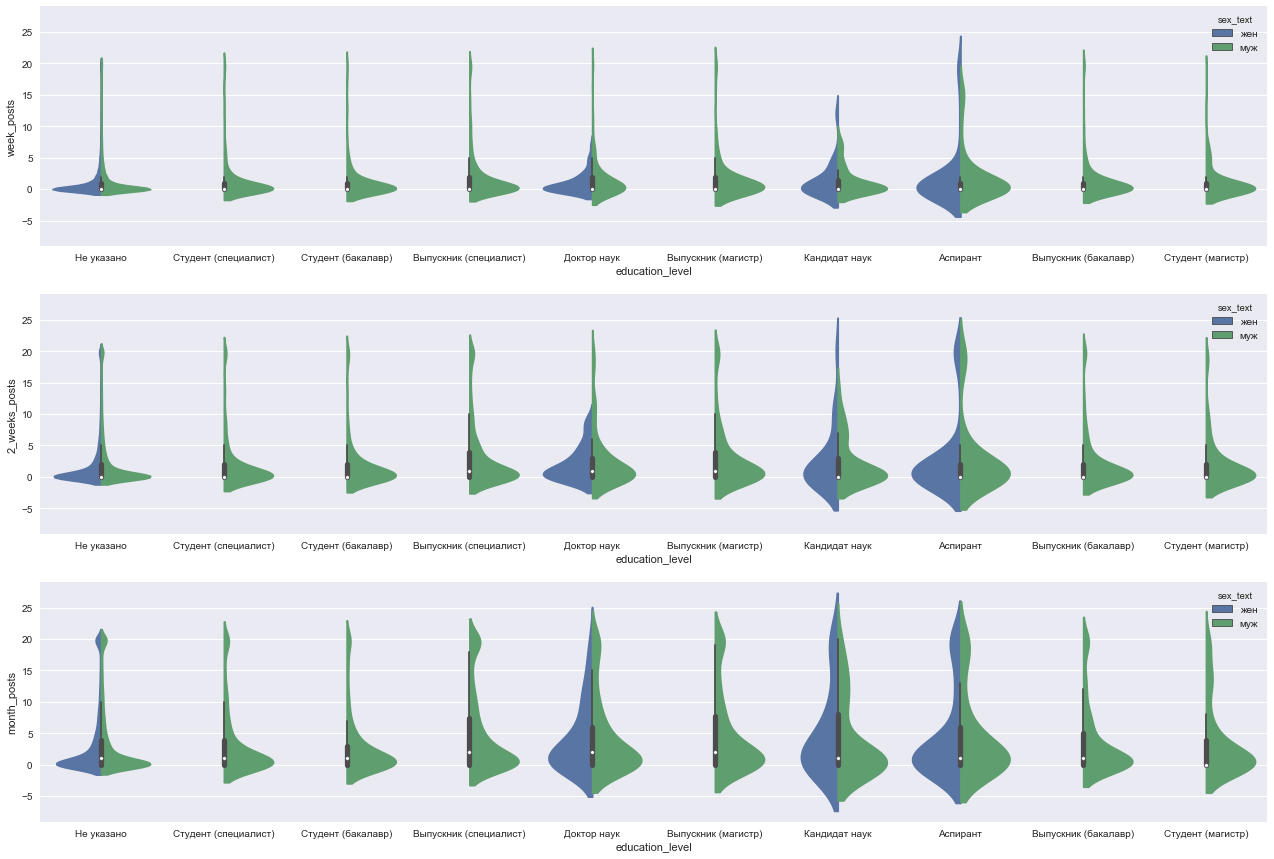

In [1043]:
violin_by_cat(users, 'education_level',22,15)

#### Топ-10 университетов

Также решил посмотреть есть ли какая-то зависимость от престижа университета. Для этого взял [рейтинг](https://raexpert.ru/rankings/vuz/vuz_2017/) топ-10 университетов по версии "Эксперта" за 2017 год.<br>
В обоснованности методологии и адекватности ранжирования университетов полагаюсь на компетентность ресурса.

Так как у пользователя может быть несколько образований или ни одного, то нужно раскрыть поле `universities` и доставать оттуда университеты.<br>
Поэтому мы пробежимся по элементам `universities` в связке с `vk_id` и достанем лист с университетами для каждого пользователя.

In [244]:
universities = users[['uid','universities']]
unis = []
uni_users = []

for user_id, i in universities.itertuples(index=False):
    try:
        uni = ast.literal_eval(i)
        unis.append([i['name'] for i in uni if 'name' in i])
        uni_users.append(user_id)
    except Exception:
        pass
    result = pd.DataFrame({'user_id':uni_users,'university':unis}, columns=['user_id','university'])

Оказалось, что вариаций написания одного и того же вуза может быть несколько. Чтобы не тратить много времени, я решил сделать лист со всеми вариациями, которые я увидел по топ-10 вузов и проверить их в полученном выше массиве.<br>
Пройдемся по всем вузам и получим `vk id` тех, кто учился в топ-10 вузах.

In [261]:
top_10_variations = ['МГИМО (У) МИД России', 'МГИМО МИД России', 'МГИМО','МГИМО МИД России''МФТИ (ГУ)',
                     'МФТИ(ГУ)','МФТИ (ГУ)','МФТИ (ГУ) (см. в Москве) ','МФТИ (ГУ)','МФТИ','НИЯУ МИФИ',
                     'МФТИ(ГУ)','МФТИ (ГУ)','МФТИ (ГУ) (см. в Москве) ','МФТИ (ГУ)','МИФИ','ГУ-ВШЭ',
                     'НИУ ВШЭ (ГУ-ВШЭ)','НИУ ВШЭ (ГУ-ВШЭ)','МФ МГТУ им. Баумана (бывш. МГУЛ)',
                     'МГТУ им. Н. Э. Баумана','МГТУ им. Н. Э. Баумана','МГТУ им. Баумана','МГТУ им. Н.Э. Баумана',
                     'МГТУ им. Н. Э. Баумана (КФ)','МГТУ им. Н.Э. Баумана','МГУ','МФТИ','СПбГУ',
                     'НИУ ВШЭ (ГУ-ВШЭ)','МГТУ им. Н.Э. Баумана','МИФИ','МГИМО МИД России','СПбГУ Политех',
                     'ТПУ','НГУ']

In [293]:
tops = []

for user_id,i in result.itertuples(index=False):
    for el in i:
        tops.append(user_id)

tops = pd.Series(tops).unique()

In [302]:
print('Похоже у меня неплохое окружение: {0:.2f}% учились в топ-10 вузах.'.format(len(tops)/len(result['university'])*100))

Похоже у меня неплохое окружение: 68.04% учились в топ-10 вузах.


Сделаем бинарную переменную и добавим в датафрейм.

In [320]:
 users['top_10_universities'] = users.uid.isin(tops)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Различия между пользователями из топ-10 вузов с точки зрения постинга практически нет, но по межквартильному размаху можно сказать, что выпускники топ-10 вузов более активны с точки зрения постинга - 75% пользователей постят до 10 постов в месяц.

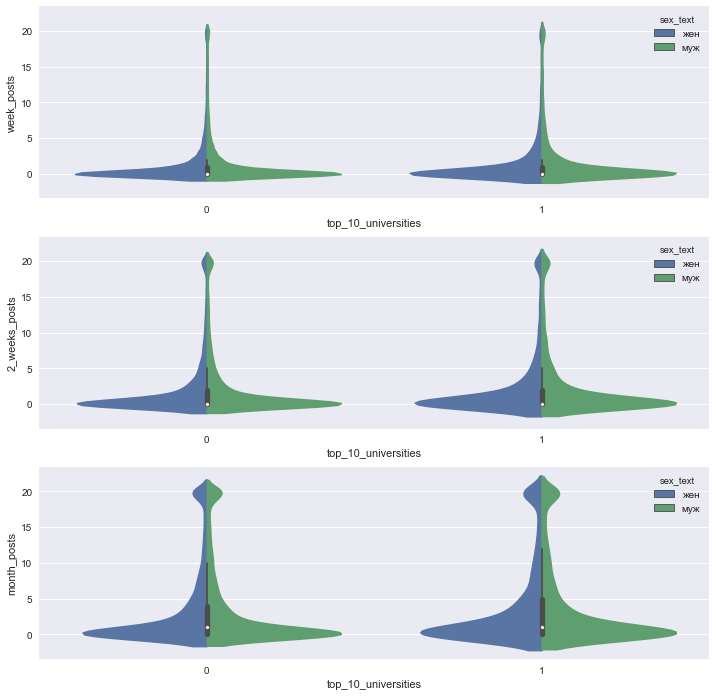

In [1067]:
violin_by_cat(users,'top_10_universities',12,12)

### 3.2.3. Считаем возраст

Так как у нас разный формат даты рождения, то выделим только тех пользователей, у которых указана полная дата рождения и посчитаем их возраст.

In [54]:
today = dt.datetime.now()
users['bdate'] = users['bdate'].astype(str)

users['age'] = users['bdate'].map(lambda x: relativedelta(today,pd.to_datetime(x)).years if len(x) > 5 else np.nan)

Возраст указывают уже больше людей, чем образование.

In [ ]:
print(users['age'].isnull().value_counts(normalize=True)*100)
print('---')
print('Минимальныый возраст: {}'.format(users['age'].min()))
print('Максимальный возраст: {}'.format(users['age'].max()))
print('Мода возраста: {}'.format(users['age'].mode()))

Разобъем на 50 бинов и посмотрим на распределение возрастов. <br>
Очевидно, что в VK сконцентрирована молодая аудитория, что подтверждается тем, что ~50% выборки лежит внутри диапазона в `[26.0, 39.0]` лет.<br>
Также выборка довольно сильно зависит и от окружения. Тк мне 25 лет и мы основывались на выборке моих друзей, то умозрительно, что я общаюсь внутри своего поколения у должно превалировать молодое поколение.
В моем случае, распределение возраста бимодальное `[0.0, 26.0]`- большинство пользователей в возрасте `26.0` лет, а `0.0` это незаполненные поля. <br>

_Интересное примечание_, что в районе 117 лет у нас есть заметный выброс. На самом, деле 117 лет назад это 1901 год - самый первый год который возможно поставить в настройках возраста. На странице у этих пользователей он не отображается, соответственно, это дефолтная настройка профиля или что-то подобное. Выброс в районе 100 лет, это тоже красива цифра, которую любят ставитьпользователи в молодом возрасте.

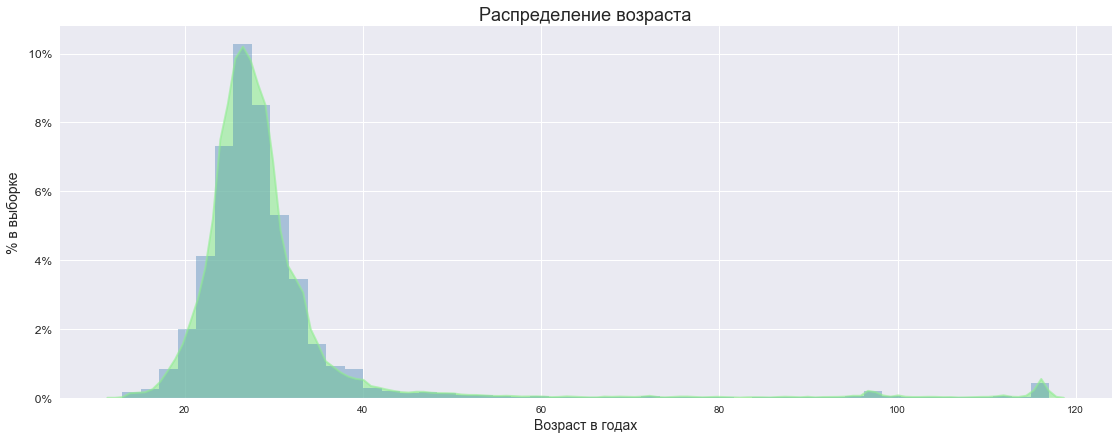

In [1068]:
#pd.cut(users['age'], 50,).value_counts(normalize=True).sort_index().plot(kind='bar', figsize=(15, 7),rot=45)
ax = sns.distplot(users[~users['age'].isnull()]['age'],bins=50, color='steelblue',
            kde=True, kde_kws={"color": "lightgreen", "alpha":0.6, "linewidth": 2, "shade":True })
vals= ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals], fontsize=12)

plt.title('Распределение возраста', fontsize=18)
plt.xlabel('Возраст в годах', fontsize=14)
plt.ylabel('% в выборке', fontsize=14)
plt.tight_layout()
plt.show()

Разобъем постинг за месяц по полу и увидим, что **женщины в возрасте от до 27 постят больше**, чем _мужчины_ в этом же возрасте.<br>
**Мужчины старше 27 лет постят больше**, чем _женщины_ и эта пропорция только увеличивается.

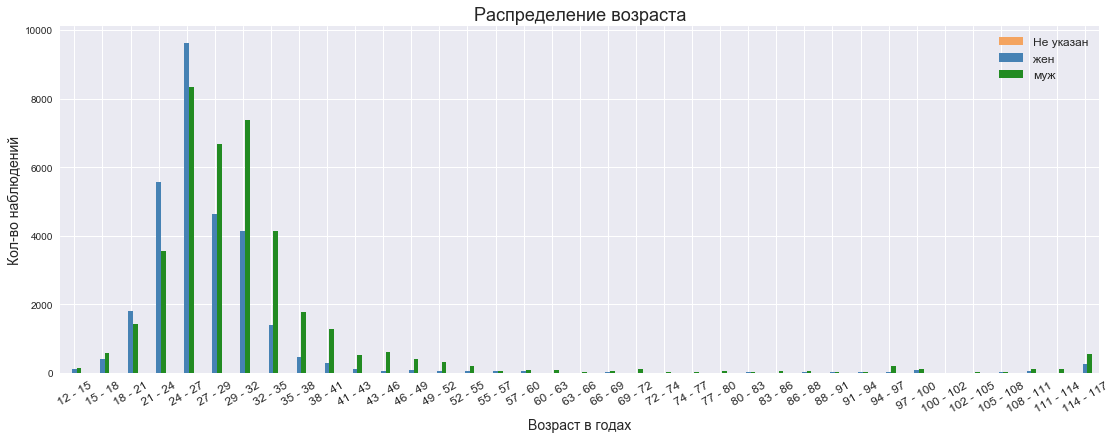

In [1102]:
plt.figure(figsize=(16,15))
users[~users['age'].isnull()].groupby(['sex_text', pd.cut(users[~users['age'].isnull()].age, 37)])['month_posts'].sum().unstack().unstack().unstack().plot(kind='bar',rot=30,color=['sandybrown','steelblue', 'forestgreen'])

### преобразуем катгории в лэйблы ###
cats = users[~users['age'].isnull()].groupby(['sex_text', pd.cut(users[~users['age'].isnull()].age, 37)])['month_posts'].sum().unstack().unstack().unstack().index
cats_from = cats.astype(str).str.strip('(]').str.split('.').str[0]
cats_to = cats.astype(str).str.strip('(]').str.split('.').str[1].str.split(',').str[1]
new_labels = cats_from+' -'+cats_to 
###

plt.title('Распределение возраста', fontsize=18)
plt.xlabel('Возраст в годах', fontsize=14)
plt.ylabel('Кол-во наблюдений', fontsize=14)
plt.legend(fontsize=12)

ax = plt.gca()
ax.set_xticklabels(new_labels, fontsize=12)
plt.tight_layout()
plt.show()

### 3.2.5. Семейное положение

Переведем категории в более удобный текстовый вид и замэппим по **`vk id`**.<br>
Какой-либо статус положения присутствует у ~40% выборки, что уже лучше.

In [57]:
relation_dict = {'1.0' : 'не женат/не замужем','2.0': 'есть друг/есть подруга','3.0': 'помолвлен/помолвлена',
                 '4.0': 'женат/замужем','5.0': 'всё сложно','6.0': 'в активном поиске','7.0': 'влюблён/влюблена',
                 '8.0': 'в гражданском браке','0.0': 'не указано'}

users['relation_text'] = users.relation.astype(str).map(relation_dict)

In [58]:
users.relation.astype(str).map(relation_dict).value_counts(normalize=True)*100

не указано                58.677818
женат/замужем             17.796762
не женат/не замужем       12.147947
влюблён/влюблена           4.818459
в активном поиске          2.628795
есть друг/есть подруга     2.441166
помолвлен/помолвлена       0.860297
всё сложно                 0.628755
Name: relation, dtype: float64

В целом по межквартильному размаху можно увидеть, что **концентрация пользователей с статусом влюбленных и помолвленных с большим количеством постов за месяц выше**, чем например у пользователей, у которых _"все сложно"_- они постят намного меньше других.

_Женщины_ постят меньше всего когда _"все сложно"_, а _мужчины_ когда _"есть подруга"_. <br>

"В активном поиске" **мужчины более активны**, чем _женщины_.<br>

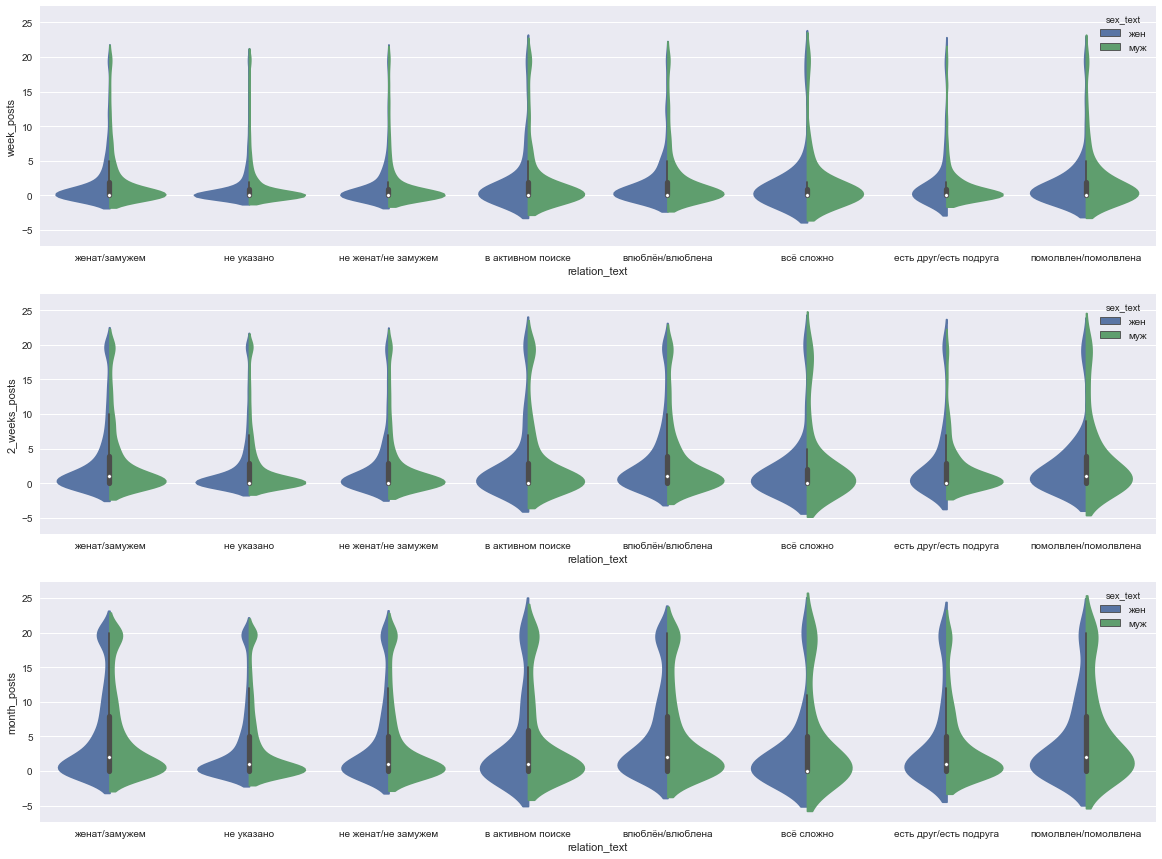

In [1070]:
violin_by_cat(users, 'relation_text', 20,15)

### 3.2.6. Политические взгляды

In [60]:
political_dict = {'1.0' : 'коммунистические','2.0': 'социалистические','3.0': 'умеренные',
                 '4.0': 'либеральные','5.0': 'консервативные','6.0': 'монархические','7.0': 'ультраконсервативные',
                 '8.0': 'индифферентные','9.0': 'либертарианские', 'Не указано':'Не указано'}

users['political_text'] = users['personal.political'].astype(str).map(political_dict)s

На месячном графике видно, что _женщины с социалистическими/ коммунистическими взглядами_ постят меньше, чем женщины с остальными политическими взглядами.<br>

У **мужчин** же напротив, плотность пользователей с б**о**льшим количеством постов и **коммунистическими взглядами** превалирует над остальными убеждениями. У женщин активность в **ультраконсервативном** лагере сильнее всего.

Также видно, что активность у пользователей с либертарианскими взлядами сильно отличается друг от друга - мужчины постят мало, а женщины больше, возможно просто мужчины простоне знают, что значат эти ценности и указыывают их в редком случае.<br>

В среднем, активность **больше** у **социалистически-направленных пользователей**.

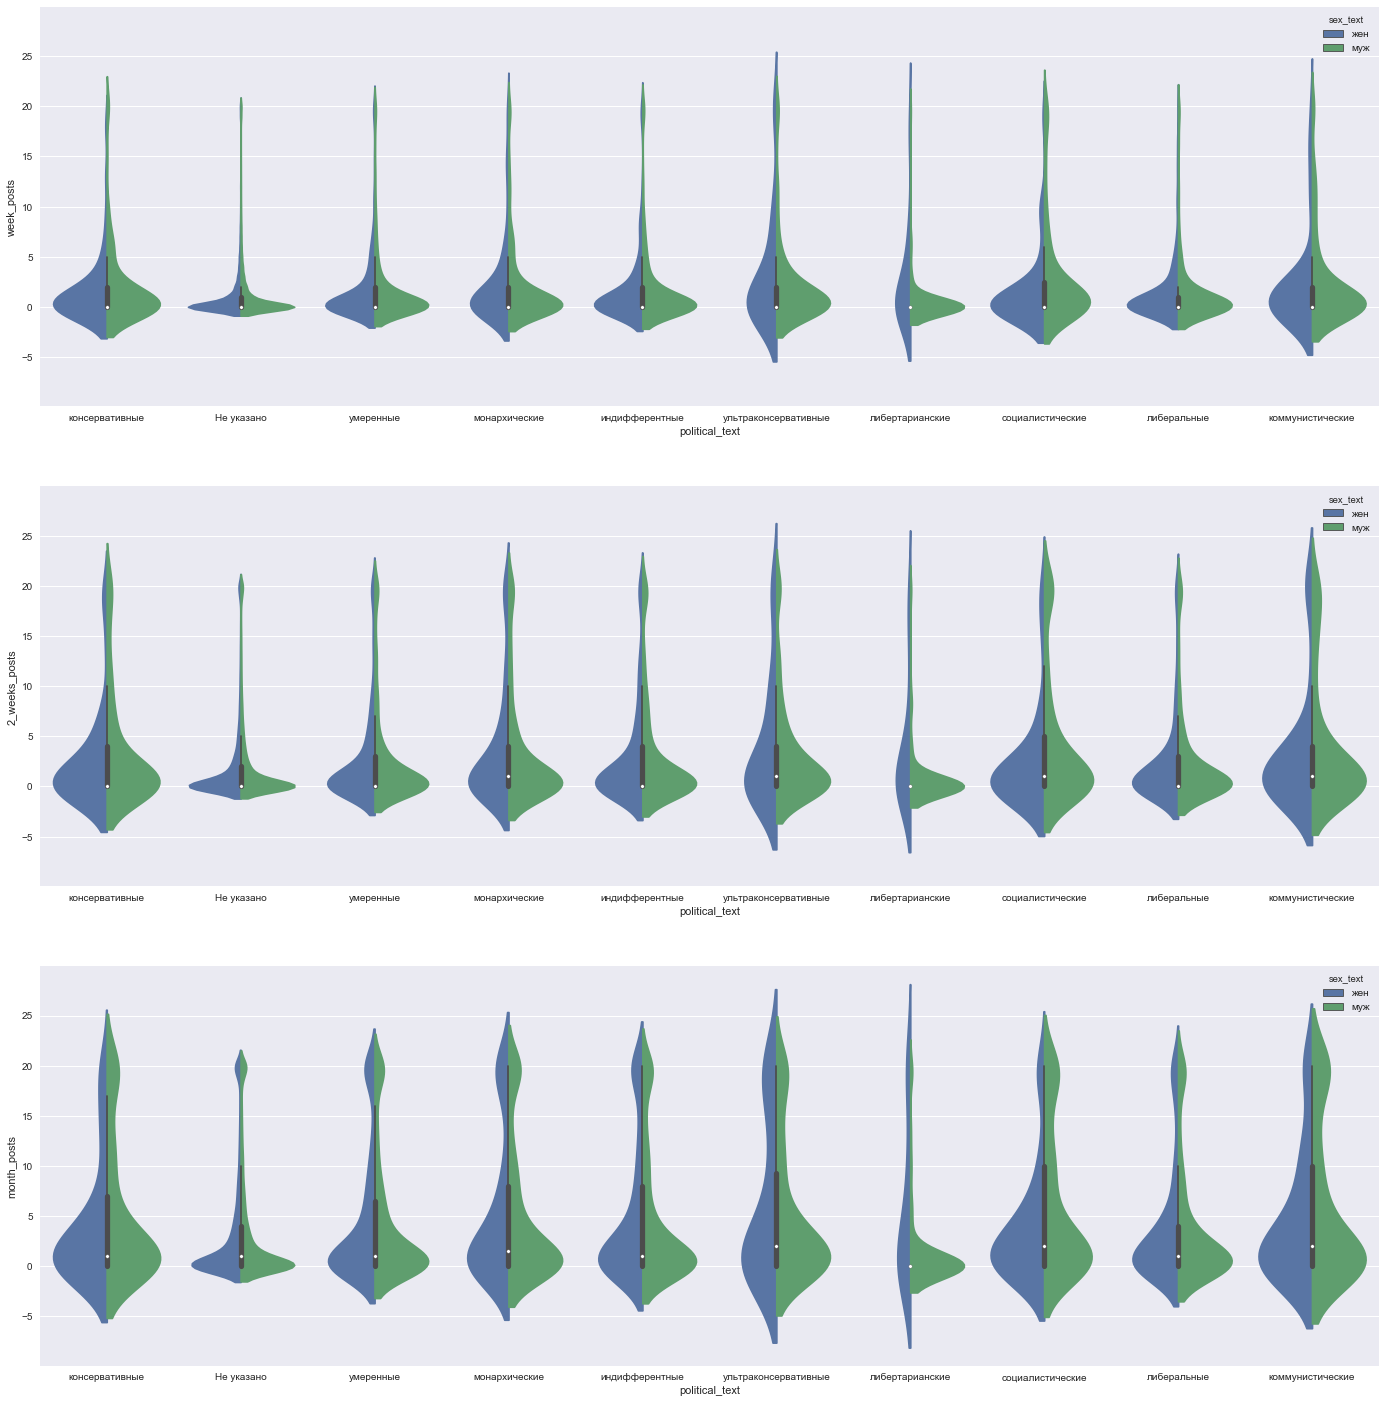

In [1071]:
violin_by_cat(users,'political_text', 24,25)

### 3.2.7. Главное в жизни

In [205]:
main_life_dict = {'1.0' : 'семья и дети','2.0': 'карьера и деньги','3.0': 'развлечения и отдых',
                 '4.0': 'наука и исследования','5.0': 'совершенствование мира','6.0': 'саморазвитие','7.0': 'красота и искусство',
                 '8.0': 'слава и влияние','0.0':'Не указано'}


users['main_life_text'] = users['personal.life_main'].astype(str).map(main_life_dict)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Видно, кому важно "**наука и исследование**" постат много, но  **концентрация мужчин**, которые постят много выше чем _женщин_ поэтому категория в среднем уступает "**совершенствование мира**"/ "**красота и искусство**" (хорошо видно по межквартильному размаху).<br>

Концентрация высоко-активных пользователей, кому важны "_карьера и деньги_" и "_развлечение и отдых меньше_", меньше, чем по другим направлениям.<br>

Забавно, но женщины с главным "**саморазвитие**" постят больше, чем мужчины, что вобщем-то умозрительно.

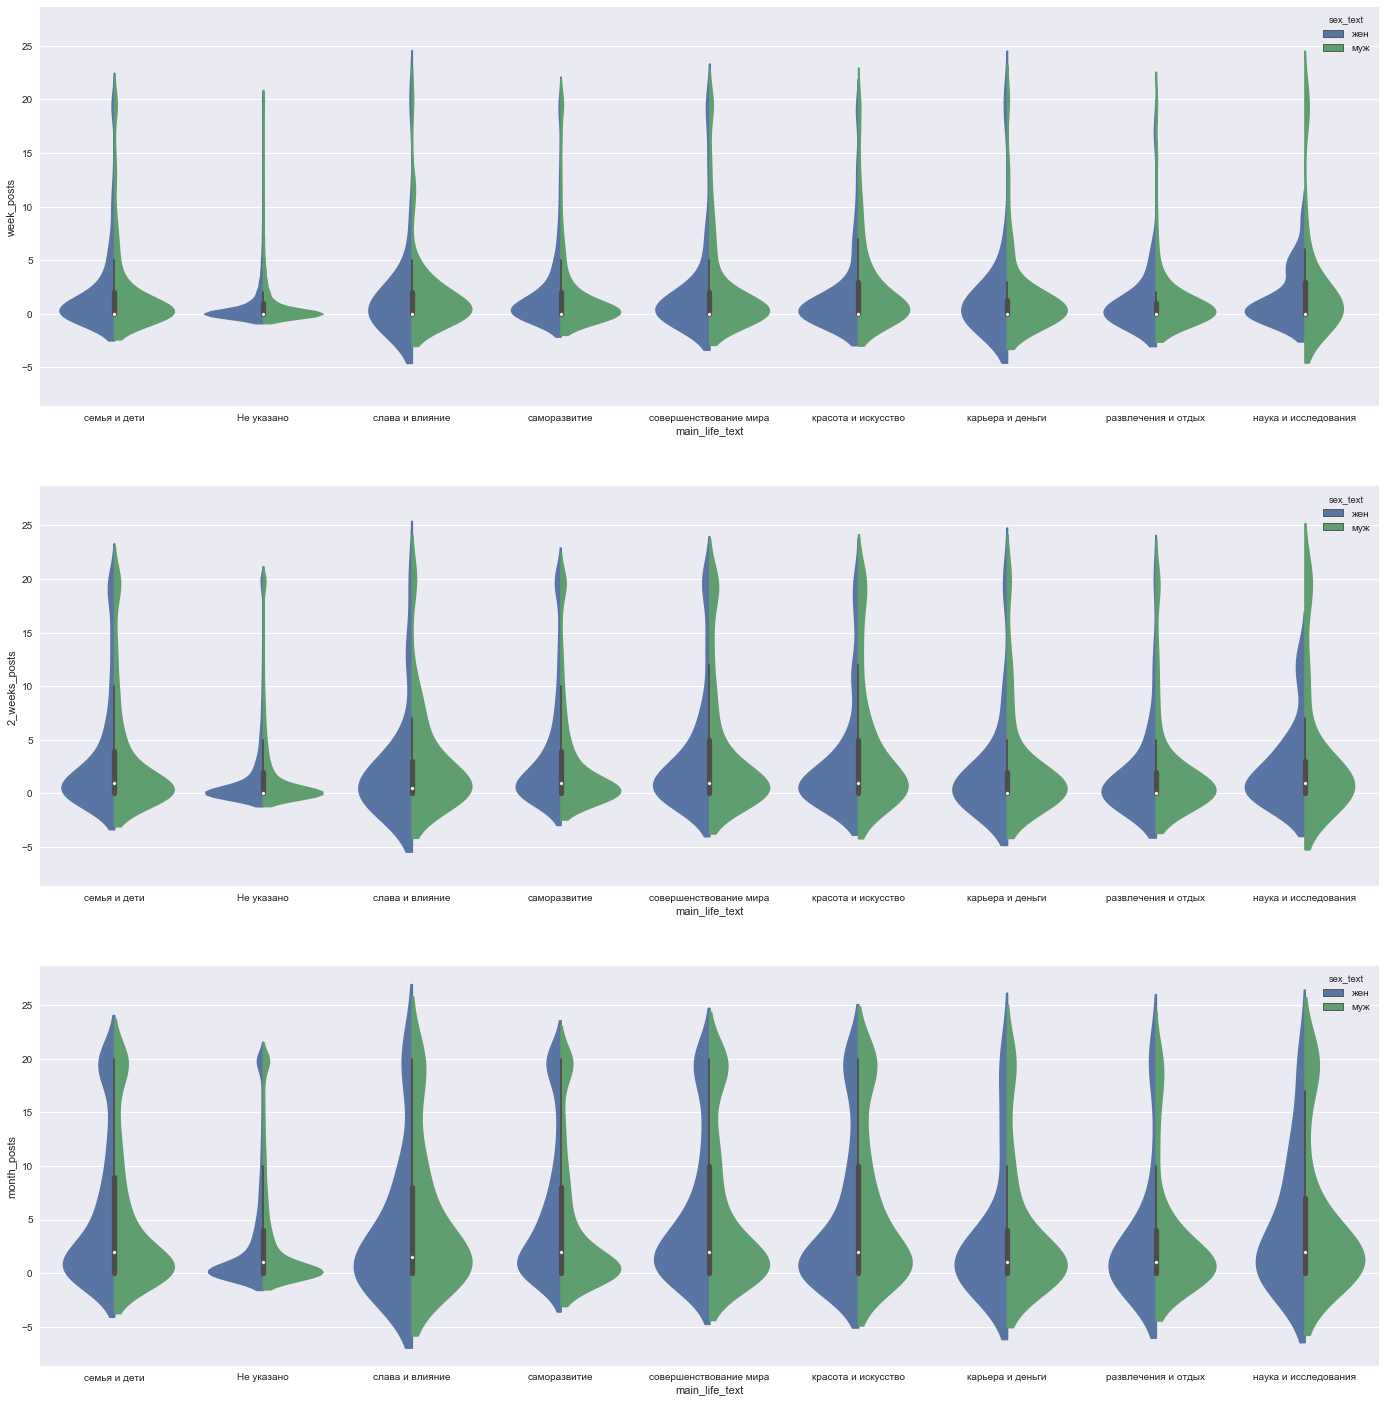

In [1072]:
violin_by_cat(users,'main_life_text', 24,25)

### 3.2.8. Главное в людях.

In [373]:
main_people_dict = {'1.0' : 'ум и креативность','2.0': 'доброта и честност','3.0': 'красота и здоровье',
                 '4.0': 'власть и богатство','5.0': 'смелость и упорство','6.0': 'саморазвитие','7.0': 'красота и искусство',
                 '8.0': 'слава и влияние','0.0':'Не указано'}


users['main_people_text'] = users['personal.people_main'].astype(str).map(main_people_dict)


Сразу заметно различие в постинге пользователей, у которых главное в жизни "власть и богаство" _женщины очень пассивны_ с точки зрения постинга, а распрделение **мужчин более вытянутое вдоль числовой прямой постинга**. <br>

_Мужчины_ у которых стоит "_власть и богаство_" так же постят меньше, чем с остальными категориями, видимо предпочитают тратить время на достижение своей главной цели вне соцсети.

Также, плотность **женщин** с большим количеством постов выше среди тех, у кого стоит "**доброта и честность**", а у 
**мужчин** среди тех, у кого - "**власть и богаство**"/"**саморазвитие**".

В целом, меньше всего постят те, для которых главное это "**красота и здоровье**"/"**доброта и честностьы**" - виолончель без узкой шей показывает концентрацию пользователей вдоль всей числовой прямой.

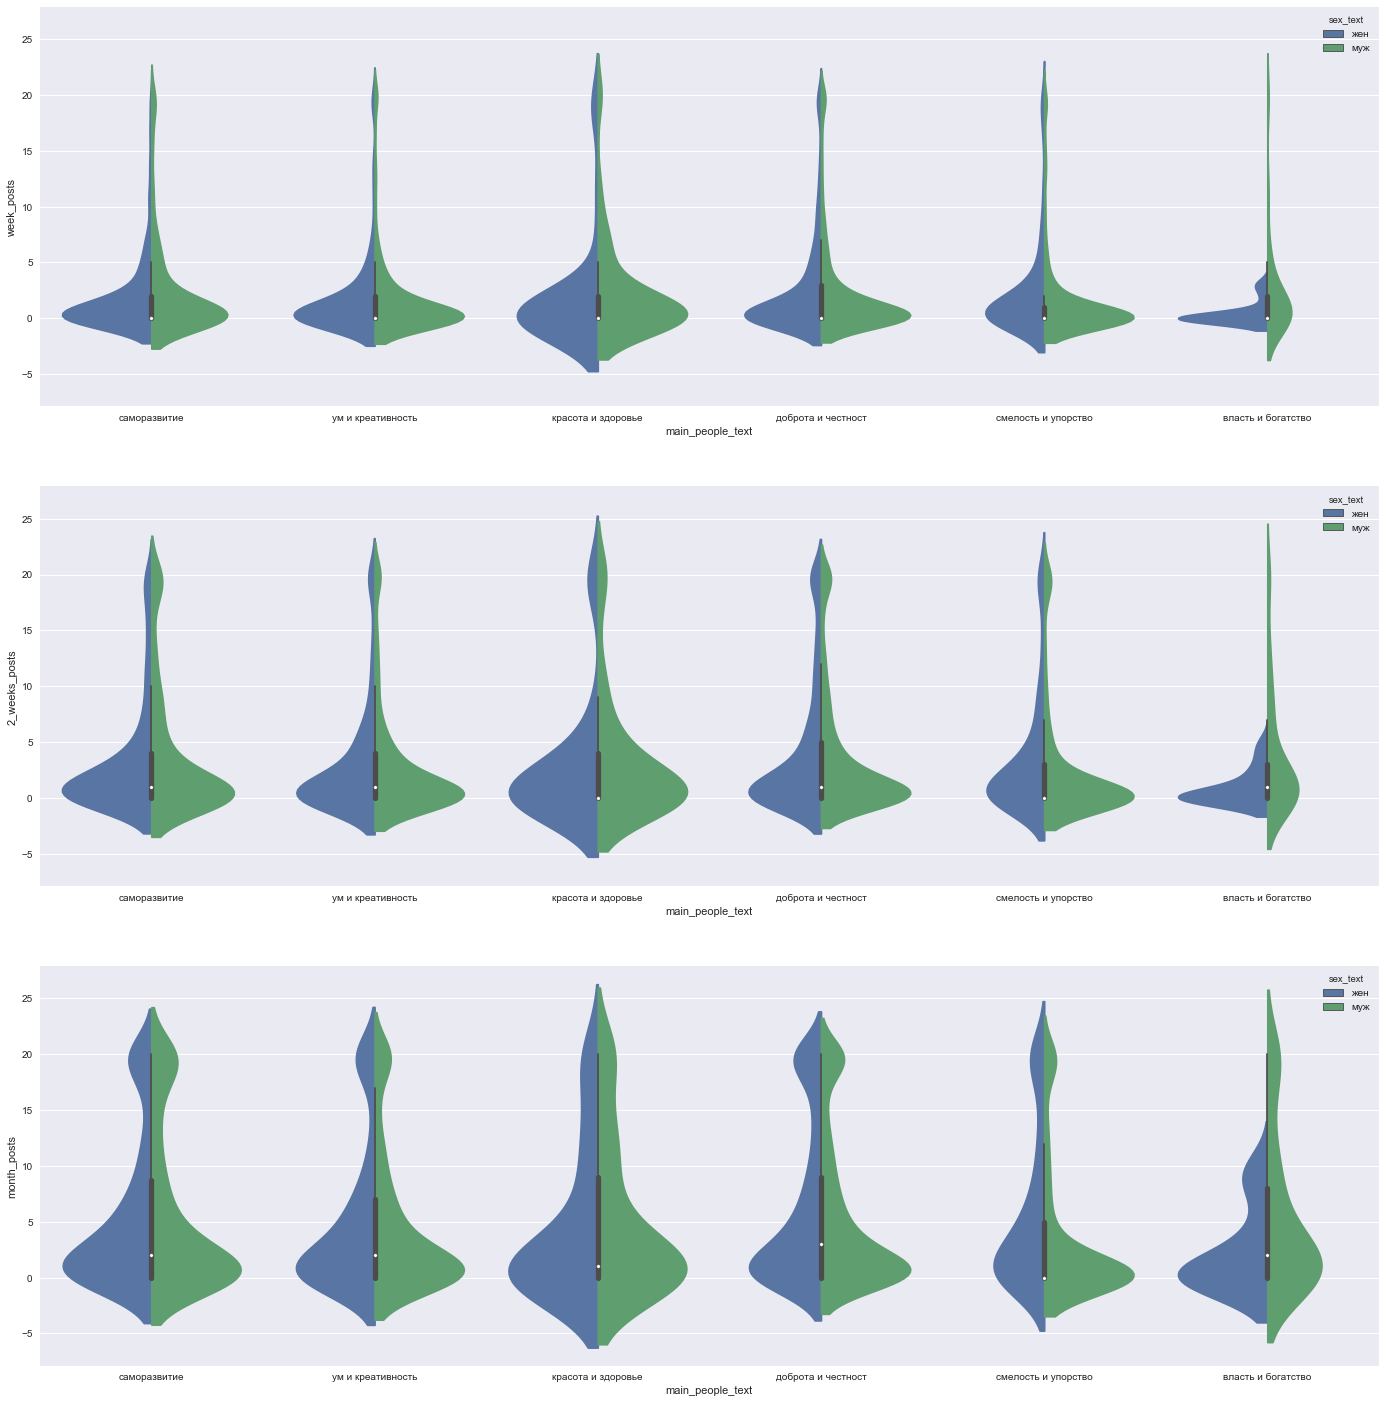

In [1073]:
violin_by_cat(users,'main_people_text', 24,25)

### 3.2.9. Языки

Языки были отброшены, ввиду того что заполнены всего у ~ 9% **`vk id`**.

### 3.2.10. Платформа посещения

In [90]:
users = users.merge(users_[['uid','last_seen.platform']], how='left', on='uid')

В объекте `'last_seen.platform'` доступно много платформ, но попробуем слить их в более крупные. Я решил объединить приложение для `Windows 10` c браузерной версией, отдельно слить `iphone` и `ipad` в `ios`, мобильную версию объединить с `VK mobile` и отдельно представить `android` и `windows phone`.

In [531]:
users = pd.merge(users,users_[['uid','last_seen.platform']], on='uid', how='left')

In [536]:
platform_dict = {'1.0' : 'mobile','2.0': 'ios_app','3.0': 'ios_app','4.0': 'android_app',
                 '5.0': 'windows_app','6.0': 'desktop','7.0': 'desktop','8.0': 'mobile', 
                 'Не указано':'Не указано'}

users['platform_text'] = users['last_seen.platform'].astype(str).map(platform_dict)

In [537]:
users['platform_text'].value_counts(normalize=True)*100

ios_app        39.225357
desktop        27.867180
android_app    20.326949
mobile         12.234009
windows_app     0.346506
Name: platform_text, dtype: float64

При разбивке на платформы на месячном графике можно заметить, что **мужчины больше постят с компьютеров**, а женщины из мобильных приложений.<br>
Количество постов по межквартильному размаху у пользователей `android` больше, чем у пользователей `ios`, а так же видно что **женщины немного больше постят с android**. Плотность распределения пользователей `ios` по полу более-менее однородна.
<br>
Так же видно, что несмотря на немногочисленность, **платформа Windows на втором месте** по месячному кол-ву постов, а так же постят с нее **больше мужчины**, чем женщины.

Тем не менее, такая интерпритяция имеет некое допущение, ведь мы смотрим единичный срез по последней платформе посещения.

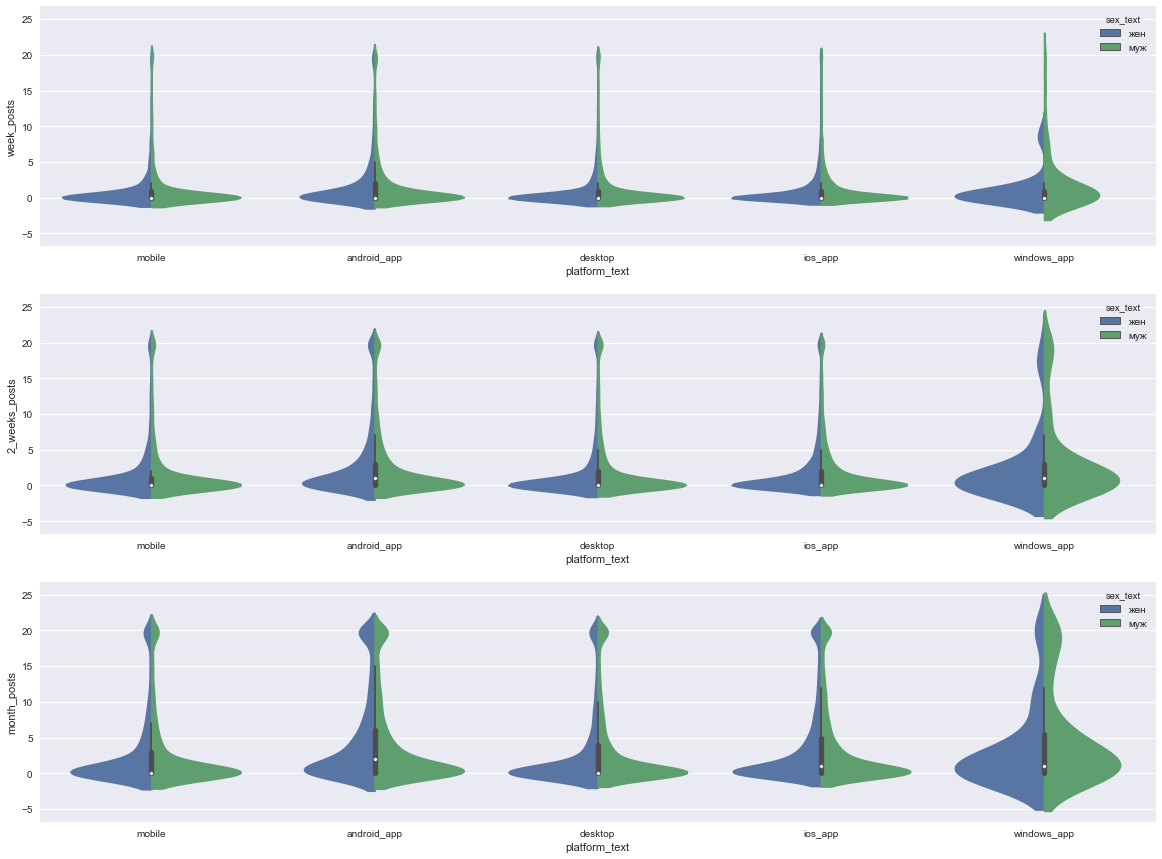

In [1074]:
violin_by_cat(users,'platform_text', 20,15)

### 3.2.11. Отношение к алкоголю и курению.

Поля про вревдные привычки не особо заполнены, но все же попытаемся посмотреть, что они покажут.

In [369]:
alco_smoking_dict = {'1.0':'резко негативное', '2.0':'негативное', '3.0':'компромиссное', 
                     '4.0':'нейтральное', '5.0':'положительное','Не указано':'Не указано'}

In [385]:
users['alco_text'] = users['personal.alcohol'].map(alco_smoking_dict) 
users['smoking_text'] = users['personal.smoking'].map(alco_smoking_dict) 

In [382]:
users['alco_text'].value_counts(normalize=True).sort_index()*100

Не указано          90.821978
компромиссное        2.042836
негативное           2.007034
нейтральное          2.548280
положительное        0.888739
резко негативное     1.691132
Name: alco_text, dtype: float64

In [386]:
users['smoking_text'].value_counts(normalize=True).sort_index()*100

Не указано          90.607165
компромиссное        1.185688
негативное           2.950530
нейтральное          2.139713
положительное        0.631805
резко негативное     2.485100
Name: smoking_text, dtype: float64

Взглянув на поля отношения к вредным привычкам, можно лишь судить, что активность пользователей с **негативным/положительным отношение к алкоголю** и **негативным/положительным отношение к курению** выше, чем по другим категориям, независимо от пола. Можно предположить, что баланс сил примерно равный или больше людей сформировали какое-то четкое отношение к легализованным наркотикам к своим годам.<br>

**Мужчины с положительным отношением к алкоголю** постят немного больше остальных категорий в разрезе пола. У женщин же наоборот, активность выше у тех, кто **отрацательно относится алкоголю**, а меньше у тех, кто **положительно**.<br>

Относильно курения, в среднем большее количество постов присуще пользователям с **положительным отношением**, а меньше всего постят те, кто не указал своего отношения.


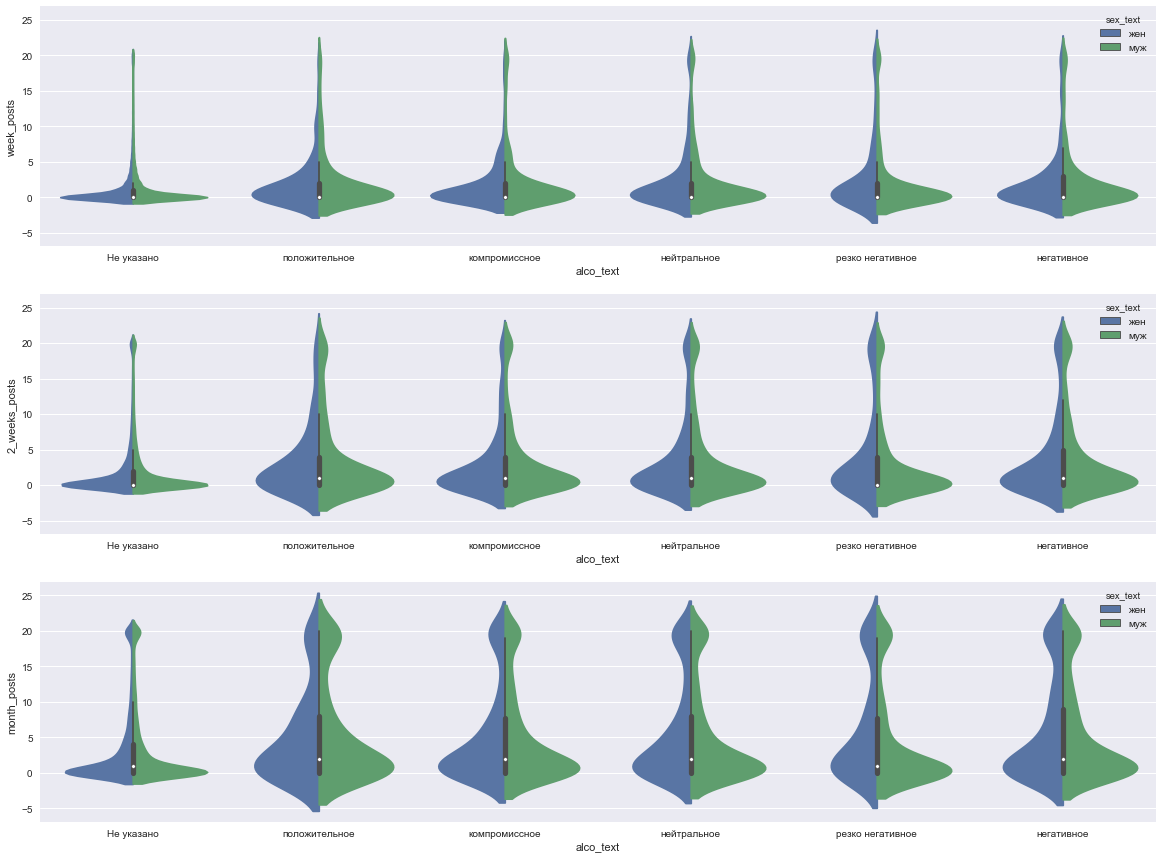

In [1075]:
violin_by_cat(users,'alco_text', 20,15)

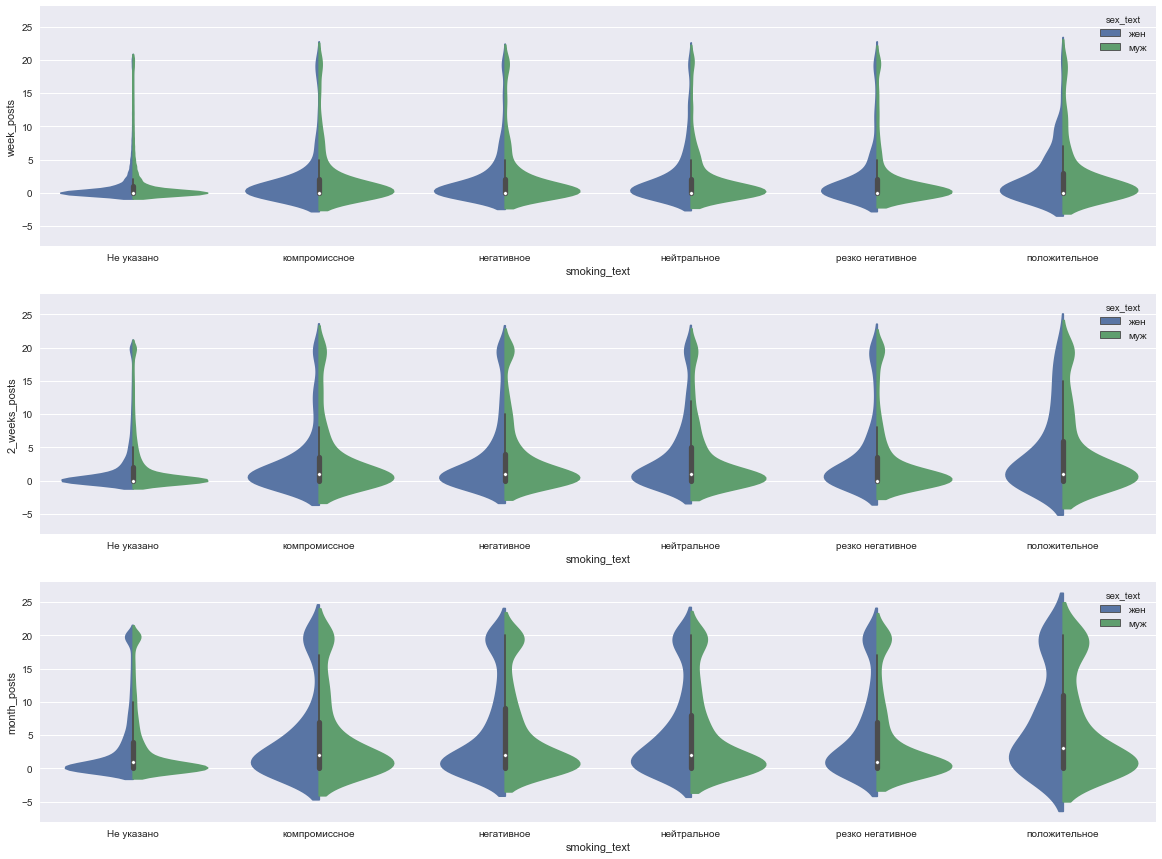

In [1076]:
violin_by_cat(users,'smoking_text', 20,15)

## 4.2.12 Характер постинга

Также я решил проверить характер постинга в зависимости от времени суток и дней недели.<br>
Сделаем табличку со всеми постами и объединим с ключевой таблицеи посмотрим статистике в разрезе пола.

In [20]:
date_posts = []
date_users = []

month_ago = (pd.Timestamp(2018,1,26,0,0,0) - pd.Timedelta(weeks=4))


for user_id in list(wall_pickle.keys()):
    for i in wall_pickle[user_id]['items']:
        if ((pd.to_datetime(i['date']*10e8)) >= month_ago):
            date_posts.append(i['date'])
            date_users.append(user_id)
            
all_month_posts = pd.DataFrame({'user_id':date_users, 'date':date_posts}, columns = ['user_id', 'date'])
all_month_posts['date'] = pd.to_datetime(all_month_posts['date']*10e8)

all_month_posts['weekday'] = all_month_posts['date'].dt.weekday
all_month_posts['hour'] = all_month_posts['date'].dt.hour

date_merge = pd.merge(users[['uid','sex_text']], all_month_posts, how='right', left_on='uid', right_on='user_id')

На распределении активности по дням недели виден максимум в середине недели и минимум в окончании рабочей недели. Каких либо особенностей активности в разрезе пола не видно, поэтому далее посмотрим на распределение по часам в течение дня.

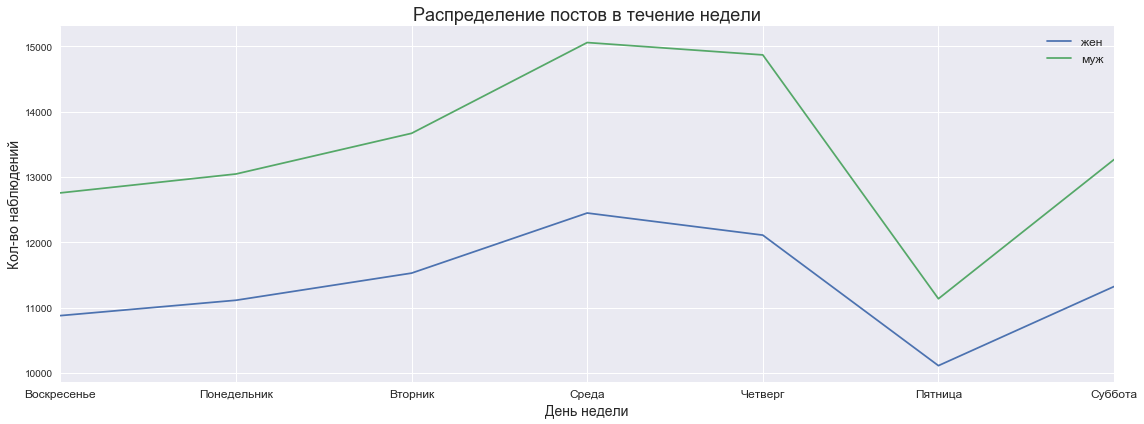

In [119]:
date_merge.groupby(['sex_text','weekday']).size().unstack().T.plot(figsize=(16,6))

plt.title('Распределение постов в течение недели', fontsize=18)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Кол-во наблюдений', fontsize=14)
plt.legend(fontsize=12)
####
labels = date_merge.groupby(['sex_text','weekday']).size().unstack().T.index
weekday_dict = {0:'Воскресенье',1:'Понедельник',2:'Вторник',3:'Среда',4:'Четверг',5:'Пятница',6:'Суббота'}
new_labels = pd.Series(labels).map(weekday_dict)
###
ax = plt.gca()
ax.set_xticklabels(new_labels, fontsize=12)
plt.tight_layout()

На графике распределения постов во времени виден очевидный паттерн - активность пользователей возрастает с утра и до обеда, после чего идет некий спад, связанный с трудовой деятельностью/ учебой/ потом активность наростает и выыходит на пик вечером и идет на спад к ночи, достигая минимума ~ 2 ночи, когда все ложатся спать. Ночью постят скорее всего автопостинги сообществ(~ посты по расписанию в группах).

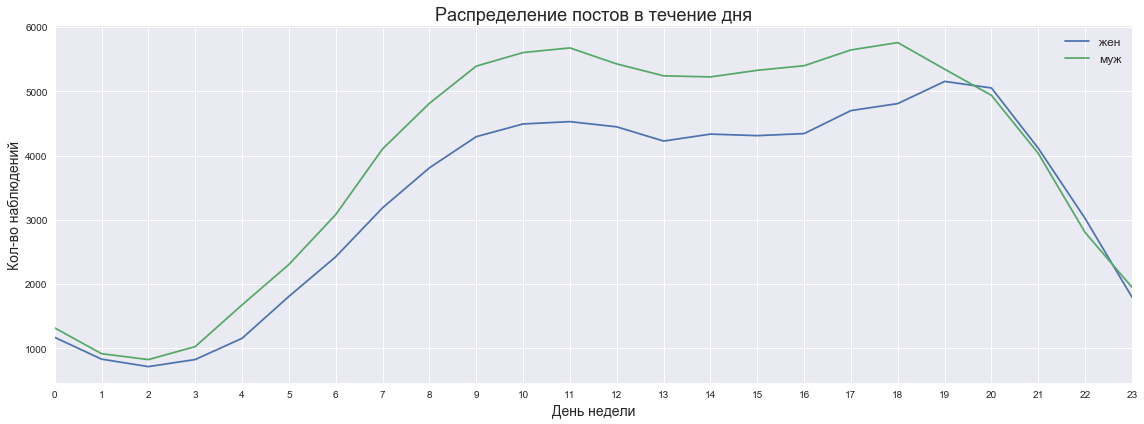

In [95]:
date_merge.groupby(['sex_text','hour']).size().unstack().T.plot(figsize=(16,6))

plt.title('Распределение постов в течение дня', fontsize=18)
plt.xlabel('День недели', fontsize=14)
plt.ylabel('Кол-во наблюдений', fontsize=14)
plt.legend(fontsize=12)

ticks = date_merge.groupby(['sex_text','hour']).size().unstack().T.index
plt.xticks(np.arange(min(ticks), max(ticks)+1, 1.0))
plt.tight_layout()
plt.show()

Какого-то значительного отличия не обнаружено, поэтому эти фичи не использовались в дальнейшем построение классификатора.

# 4. Построение классификатора
<a id='classifier' ></a>

## 4.1. Попытка построения с Catboost.
<a id='catboost' ></a>

Попробуем построить классификатор на тех данных, что у нас есть.<br>
Построим бинарный таргет для тех кто много постит и возьмем всех, у кого постов больше 12, так чтобы в 1 классе у нас оказалось 12% выборки. Попробуем предсказать на такой синтетической разметке.

In [5]:
pd.cut(users['month_posts'],10).value_counts(normalize=True).sort_index()*100

(-0.02, 2.0]    65.712189
(2.0, 4.0]       9.407819
(4.0, 6.0]       5.473221
(6.0, 8.0]       3.857038
(8.0, 10.0]      2.658002
(10.0, 12.0]     2.079447
(12.0, 14.0]     1.507180
(14.0, 16.0]     1.205324
(16.0, 18.0]     1.025050
(18.0, 20.0]     7.074730
Name: month_posts, dtype: float64

In [6]:
users['target'] = users['month_posts'].apply(lambda x: 1 if x >12.0  else 0)

Так как у нас есть численные и категориальные признаки и пропуски в данных, воспользуемся библиотекой `Catboost`, которая удобно с этим справлется.

In [7]:
from catboost import CatBoostClassifier, Pool
import lightgbm as lgbm
from sklearn.metrics import recall_score, roc_auc_score, auc, confusion_matrix

/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


Выберем параметры на которых будем обучаться (как категорийные, так и количественные).

In [8]:
feature_set = ['personal.life_main','personal.people_main','sex','top_10_universities','relation',
               'personal.life_main', 'personal.people_main','personal.political',
               'followers_count','age','wall_count','instagram', 'friends_qty',
               'daily_posts','target']
cat_features = list(range(0,9)) # индексы категорийных переменных

Проведем небольшое преобразование.

In [66]:
users['personal.political'] = users['personal.political'].replace('Не указано', 0.0)
users['personal.people_main'] = users['personal.people_main'].replace('Не указано', 0.0)
users['relation'] = users['relation'].fillna(99.0)
users['relation'] = users['relation'].replace(99.0, 999.0)
users['top_10_universities'] = users['top_10_universities'].apply(lambda x: 1 if x==True else 0)
frame = users[~users.sex.isnull()][feature_set]

In [78]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(frame.iloc[:,:-1].values, 
                                                    frame['target'].values, 
                                                    test_size = 0.25, random_state=0)

Обучимся, предскажем и посмотрим на метрику `ROC_AUC score` и `confusion matrix`, которые часто используется в задачах классификации.

In [79]:
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=500, learning_rate=0.3, depth=12, loss_function='Logloss',
                           class_weights=(1,9),verbose=False)
# Fit model
model.fit(X_train, y_train, cat_features, eval_set = (X_test, y_test))

In [80]:
# Get predicted classes
preds_class = model.predict(X_test)
# Get predicted probabilities for each class
preds_proba = model.predict_proba(X_test)

from sklearn.metrics import recall_score, roc_auc_score, auc, confusion_matrix
print( 'ROC_AUC нашей модели: {0:.2f}'.format(roc_auc_score(y_test, preds_proba[:,1])))

cm = confusion_matrix(y_test, preds_class)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)

ROC_AUC нашей модели: 0.85
[[ 0.79372409  0.20627591]
 [ 0.26829268  0.73170732]]


Так же нарисуем графическое представление.

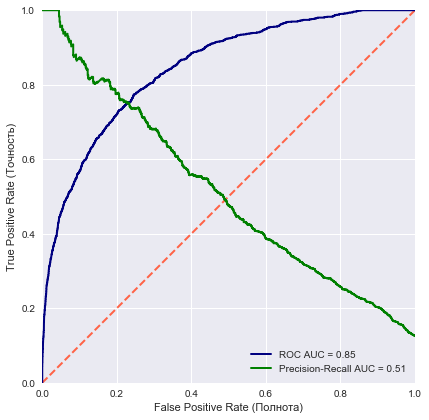

In [81]:
show_ROC_PRC(y_test, preds_proba[:,1])

Посмотрим на важность факторов.

In [26]:
catboosst_feature_importances = pd.DataFrame({'features':feature_set[:-1], 'importances':model.feature_importances_}, 
                                  columns=['features', 'importances'])
catboosst_feature_importances = catboosst_feature_importances.sort_values(by='importances', ascending=False)
catboosst_feature_importances

,features,importances
10,wall_count,45.552976
8,followers_count,15.553111
12,friends_qty,6.425681
2,sex,5.939878
9,age,4.351969
4,relation,4.154414
11,instagram,3.916584
3,top_10_universities,3.725415
7,personal.political,2.968871
1,personal.people_main,2.666544


Посчитаем наш `average_precision` на кросс-валидации из 5 фолдов, чтобы понять насколько наша модель стабильна.

Сама функция для построение графика:

In [14]:
def show_ROC_PRC(y_test, y_score):
    import sklearn.metrics
    FPR, TPR, _ = sklearn.metrics.roc_curve(y_test, y_score)
    auc = sklearn.metrics.roc_auc_score(y_test, y_score)
    precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_score)
    average_precision = sklearn.metrics.average_precision_score(y_test, y_score)
    
    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], color='tomato', lw=2, linestyle='--')
    plt.plot(FPR, TPR, lw=2, color='navy', 
             label='ROC AUC = {0:0.2f}'.format(auc))
    plt.plot(recall, precision, lw=2, color='green', 
             label='Precision-Recall AUC = {0:0.2f}'.format(average_precision))
    plt.xlabel('False Positive Rate (Полнота)')
    plt.ylabel('True Positive Rate (Точность)')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.legend(loc="lower right")
    plt.tight_layout(rect=[0.0, 0.01, 1.01, 1.0])
    plt.show()

In [27]:
model.save_model(RAW + 'model_5.bin')

## 4.2. Выводы о модели.
<a id='catboost_results' ></a>

**Выводы относительно модели:** 
Было сделано несколько итераций и экспериментов.<br>
Представлен последний вариант и видно, что алгоритм по `ROC_AUC curve` отлично справляется, но с точки зрения `Precision_recall` это так себе алгоритм, тк показывает довольно низкую точность, ввиду несбалансированности классов.<br>
Последний эксперимент включает порочную практику, а именно использует суточное количество постов как одну из переменных, которая очевидно является ликом к предсказанию разметки. Если использовать количество постов за 3 дня и неделю, то `ROC_AUC` увеличивается до **0.96** (~переобучение), но `Precision_recall` выходит на приемлимый уровень в **0.82**.
Решил оставить "неочень вариант", тк он приводит нас к тому что можно сделать для улучшения.

**Дальнейшее улучшение:** Ввиду того, что разметка у нас синтетическая, то можно либо попробовать сгенерировать осмысленную разметку на экспертном/эмперическом опыте, либо попробовать метод `undersampling`, когда мы балансируем классы с равной вероятностью. <br>
Также можно продолжить с добычей новых данных, инжинирингом переменных и тюнингом гиперпараметров модели.

# 5. Выводы.
<a id='conclusions' ></a>

* **Есть ли различия между frequent-posters и low-posters?** <br>


Если посмотреть на графики распределения количества месячных постов, то видно, что большинство людей не постят ничего на стене или
имеют несколько постов в месяц. Также есть люди, которые постят до 40 постов в месяц (по доступной нам части стены), то есть основная часть выборки довольно пассивна, но есть и активная часть пользователей, поэтому изначально я обращал большее внимание на то чтобы выделить людей, которые имеют больше постов в `VK`.<br>

Таким образом, некоторые закономерности можно представить следующим набором характеристик, описывающих абстрактный портрет в зависимости от количества постов на стене. Портреты описаны тем категориями, которые были доступны, но не ограничиваются ими. <br>


||  Мужчины | |Женщины |
|------------- |-------------  | ------------- | -------------|------------- |  
||**Много** постят  | *Мало* постят |**Много** постят|*Мало* постят|
|*Возраст*|> 24-27 лет | < 24-27 лет | < 24-27 лет | > 24-27 лет |
|*Образование*|Есть высшее образование (выпускник или высшие степени)   | Студент (бакалавр)  | Кандидат наук | Доктор наук/аспирант |
|*Семейное положение*|Возможно в романтических отношениях (помолвлен/"влюблен")   | "Есть подруга"  | "Влюблена" | "Всё сложно" |
|*Потилические взгляды*|Коммунистические/социалистические взгляды | Либертарианские взгляды  | Монархические/ ультраконсервативные взгляды | Либертарианские взгляды |
|*Главное в жизни*|Красота и искусство/ исследование и наука| Карьера и деньги/ развлечение и отдых/ саморазвитие| Совершенствование мира/ Красота и искусство/ саморазвитие | Карьера и деньги/ Развлечение и отдых |
|*Главное в людях*|Красота и здоровье/ Власть и богатство/саморазвитие | Смелость и упорство | Красота и здоровье/ доброта и честность | Власть и богатство |
|*Отношение к алкоголю*|Возможно выпивает| -  | Негативное | Положительное |
|*Дополнительно*| Возможно посещает `VK` с `Windows Phone`   | -  | Возможно сидит с `android`/ есть instagram | - |
